# Nutrisense CGM: Guide to data extraction and analysis

<img src="https://assets.nutrisense.io/62c477aa7b7db12cfffa5de3/633386632eabe28ff072973d_Activity.webp" width="200px" />



The [Abbott Freestyle Libre Version 1 Continuous Glucose Monitor](https://www.freestyle.abbott/us-en/products/freestyle-libre-3.html?utm_source=Google&utm_medium=SEM&utm_campaign=Brand&utm_content=General%20FSL3&gclid=EAIaIQobChMIyaaZs4Gv_gIVkSytBh11yQZOEAAYASAAEgIiY_D_BwE&gclsrc=aw.ds) is a sensor that tracks your blood glucose levels over a period of two weeks. A variety of vendors use the Freestyle Libre CGM; in this notebook, we use [Nutrisense](https://to.nutrisense.io/cgm-3?g_acctid=195-120-5766&g_adgroupid=145363696209&g_adid=588697352068&g_adtype=search&g_campaign=brand_exact_desktop_tcpa_conv_groups+_low_cpc&g_campaignid=18640003106&g_keyword=nutrisense%20cgm&g_keywordid=kwd-927595745176&g_network=g&utm_adgroup=conv&utm_adpos=&utm_campaign=brand_exact_desktop_tcpa_conv_groups__low_cpc&utm_keyword=nutrisense%20cgm&utm_medium=cpc&utm_source=google&gclid=EAIaIQobChMI_Ie08PTD_QIVsRR9Ch3A_wRrEAAYASAAEgJBPfD_BwE). In addition to logging continuous data, purchasing the Nutrisense CGM pairs you with a dietitian who helps you interpret, understand, and manage your glucose levels.

Having used the Nutrisense CGM, we'll show you how to extract, visualize, and compute statistics for data collected by the monitor. All you will need for this notebook is your username and password!

You can extract the parameters with known sampling frequencies as below:

Parameter Name  | Sampling Frequency
-------------------|------------------
Glucose level      |  15 minutes
Glucose Peak |  24 hours
Glucose Average |  24 hours
Glucose Adaptability | 24 hours
Glucose Variability | 24 hours

In this guide, we sequentially cover the following **nine** topics to extract from the Nutrisense CGM:
1. **Setup**
2. **Authentication/Authorization**
    - Requires only username and password, no OAuth.
3. **Data extraction**
    - We get data via `wearipedia` in a couple lines of code.
4. **Data Exporting**
    - We export all of this data to file formats compatible by R, Excel, and MatLab.
5. **Adherence**
    - We simulate non-adherence by dynamically removing datapoints from our simulated data.
6. **Visualization**
    - We create a simple plot to visualize our data.
7. **Advanced visualization**
    - 7.1: We plot a calendar heatmap of step counts every day, revealing which days the user has worn the watch.
    - 7.2: We reproduce a time series plot from the Garmin Connect website of heart rate and activity (steps) throughout a given day.
8. **Outlier Detection and Data Cleaning**
    - We detect outliers in our data and filter them out.
9. **Data analysis**
    - 9.1: We test whether activity (step counts) and heart rates within 15 minute intervals are correlated and find a statistically significant relationship.
    - 9.2: We check for a correlation between breathing rate and heart rate, and find a statistically significant link.
    - Note that we are not making any scientific claims here as our sample size is small and the data collection process was not rigorously vetted (it is our own data), only demonstrating that this code could potentially be used to perform rigorous analyses in the future.

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own email and password on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.



# 1. Setup

# 1. Setup

## Participant Setup

Dear Participant,

Once you unbox your Nutrisense CGM, please set up the device by following the Official Guide: https://support.nutrisense.io/hc/en-us/articles/4402815217687-How-Do-I-Put-on-My-CGM-

This guide is also available on the nutrisense app, which is where you will log and view your data.

Make sure that your phone is paired to it using the Nutrisense login credentials (email and password) given to you by the data receiver.

Best,

Wearipedia

## Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create a Nutrisense account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Distribute the device to the participant and instruct them to follow the participant setup letter above.
5. Install the `wearipedia` Python package to easily extract data from this device.

In [1]:
!pip install git+https://github.com/Stanford-Health/wearipedia

  Cloning https://github.com/Stanford-Health/wearipedia to /tmp/pip-req-build-6yo5af4f
  Running command git clone --filter=blob:none --quiet https://github.com/Stanford-Health/wearipedia /tmp/pip-req-build-6yo5af4f
  Resolved https://github.com/Stanford-Health/wearipedia to commit e128fc36d93c90718c404fcaf5bbc8b84811f849
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0

# 2. Authentication/Authorization

To obtain access to data, authorization is required. All you'll need to do here is just put in your email and password for your nutrisense account. We'll use this username and password to extract the data in the sections below.

In [2]:
#@title Enter Nutrisense login credentials
email_address = "foo@stanford.edu" #@param {type:"string"}
password = "foo" #@param {type:"string"}

# 3. Data Extraction

Data can be extracted via [wearipedia](https://github.com/Stanford-Health/wearipedia/), our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox.

In [3]:
#@title Enter start and end dates (in the format yyyy-mm-dd)

#set start and end dates - this will give you all the data from 2000-01-01 (January 1st, 2000) to 2100-02-03 (February 3rd, 2100), for example
start_date='2022-03-01' #@param {type:"string"}
end_date='2023-03-12' #@param {type:"string"}
synthetic = True #@param {type:"boolean"}

In [4]:
import wearipedia

device = wearipedia.get_device("nutrisense/cgm")

if not synthetic:
    device.authenticate({"email": email_address, "password": password})

params = {"start_date": start_date, "end_date": end_date}

continuous = device.get_data("continuous", params=params)
statistics = device.get_data("statistics", params=params)
scoremain = device.get_data("scores", params=params)
summary = device.get_data("summary", params=params)

100%|██████████| 109/109 [00:00<00:00, 24608.63it/s]


In [5]:
print(continuous[1])

{'x': '2022-03-01T00:30:00-08:00', 'y': 144.57506506003088, 'interpolated': False, '__typename': 'TimePair'}


# 4. Data Exporting

In this section, we export all of this data to formats compatible with popular scientific computing software (R, Excel, Google Sheets, Matlab). Specifically, we will first export to JSON, which can be read by R and Matlab. Then, we will export to CSV, which can be consumed by Excel, Google Sheets, and every other popular programming language.

## Exporting to JSON (R, Matlab, etc.)

Exporting to JSON is fairly simple. We export each datatype separately and also export a complete version that includes all simultaneously.

In [6]:
import json

json.dump(continuous, open("continuous.json", "w"))
json.dump(statistics, open("statistics.json", "w"))
json.dump(scoremain, open("scores.json", "w"))
json.dump(summary, open("summary.json", "w"))

complete = {
    "continuous": continuous,
    "statistics": statistics,
    "scores": scoremain,
    "summary": summary
}

json.dump(complete, open("complete.json", "w"))

Feel free to open the file viewer (see left pane) to look at the outputs!

## Exporting to CSV and XLSX (Excel, Google Sheets, R, Matlab, etc.)

Exporting to CSV/XLSX requires a bit more processing, since they enforce a pretty restrictive schema.

Here we will put the continuous glucose data into a dataframe.

In [7]:
import pandas as pd
import copy

# glucose scores dataframe
data = []
for elem in continuous:
  t = pd.DataFrame({'time': [elem['x']], 'level': [elem['y']], 'interpolated': [elem['interpolated']]})
  data.append(copy.deepcopy(t))

data = pd.concat(data)

display(data)

,time,level,interpolated
0,2022-03-01T00:15:00-08:00,122.153035,False
0,2022-03-01T00:30:00-08:00,144.575065,False
0,2022-03-01T00:45:00-08:00,135.063114,True
0,2022-03-01T01:00:00-08:00,133.561388,False
0,2022-03-01T01:15:00-08:00,132.108973,False
...,...,...,...
0,2022-06-17T22:45:00-08:00,135.643399,False
0,2022-06-17T23:00:00-08:00,133.796981,False
0,2022-06-17T23:15:00-08:00,122.887501,False
0,2022-06-17T23:30:00-08:00,107.835660,False


# 5. Adherence

Since the Nutrisense CGM only holds around 8 hours of data at a time, if the user forgets to sync their data to their phone on time, there'll likely be a gap with missing data. Take it from us, it happens more than you might think!

In this section, we will simulate this non-adherence over different periods of time from the participant.

Then, we will detect this non-adherence and give a Pandas DataFrame that concisely describes when the participant has had their device on and off throughout the entirety of the time period, allowing you to calculate how long they've had it on/off etc.

We will first delete a certain % of blocks, with user input.

In [8]:
#@title Non-adherence simulation
start_date='2022-03-01' #@param {type:"string"}
days=1 #@param {type:"number"}
adherence_percent = 0.94 #@param {type:"slider", min:0, max:1, step:0.01}

Now let's detect non-adherence. We will plot the periods when the participant syncs their data.

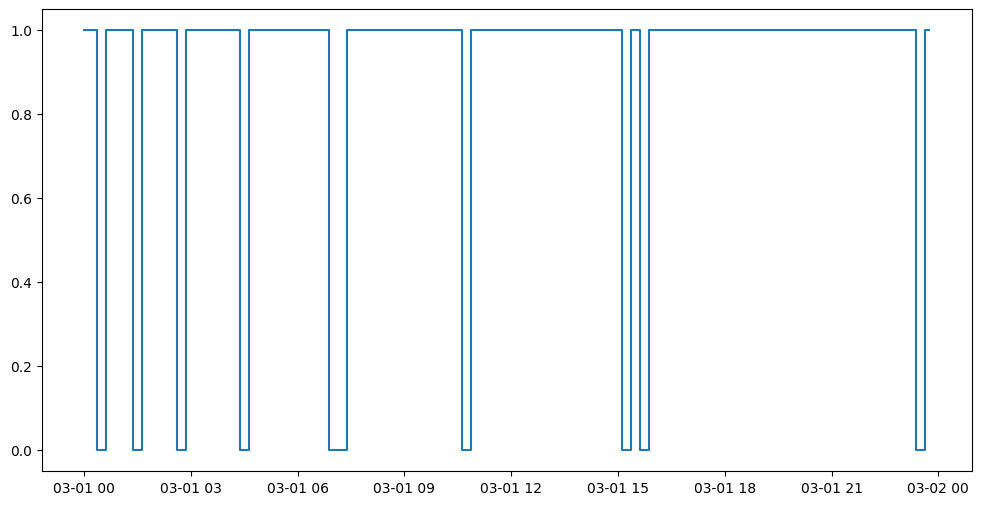

In [9]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import copy

# convert string to date
def strToD(s):
  c = s[:19]
  return datetime.strptime(c, "%Y-%m-%dT%H:%M:%S")

start = datetime.strptime(start_date, "%Y-%m-%d")
end = start + timedelta(days=days)

dta = []
for elem in continuous:
  if strToD(elem["x"]) < start:
    continue
  elif strToD(elem["x"]) > end:
    break

  dta.append(copy.deepcopy(elem))
  if np.random.uniform(low=0, high=1, size=(1,))[0] > adherence_percent:
    dta[-1]["interpolated"] = True


datelist = pd.date_range(start_date,datetime.strftime(end,"%Y-%m-%d"), freq="15min")
valid = []
for point in dta:
  if point['interpolated'] == True:
    valid.append(0)
  else:
    valid.append(1)

plt.figure(figsize=(12, 6))
datelist = datelist[:len(valid)]
plt.plot(datelist,valid,drawstyle="steps-mid")

# 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our three kinds of data in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

Text(0, 0.5, 'Continuous Glucose Dat')

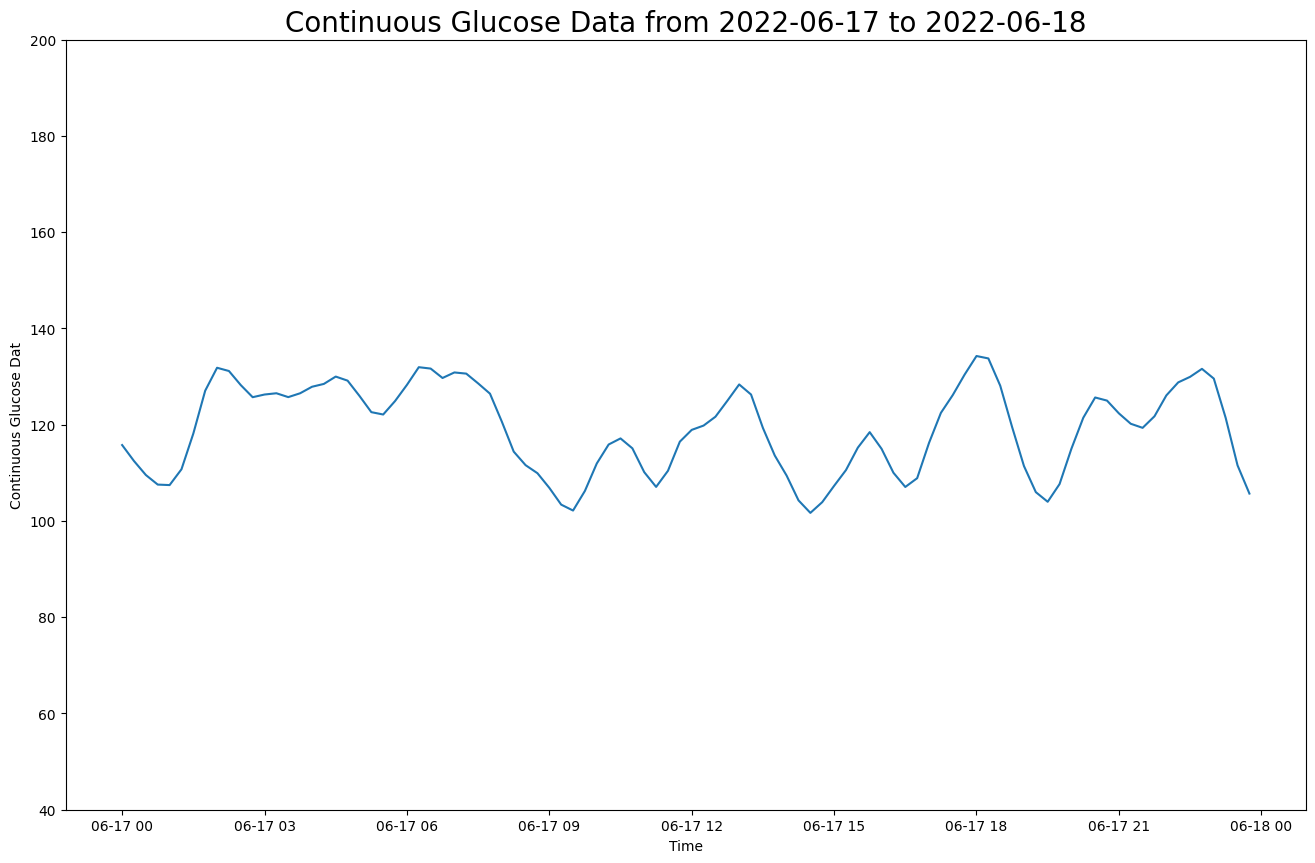

In [10]:
#@title Basic Plot
feature = "continuous" #@param ["continuous"]
start_date = "2022-06-17" #@param {type:"date"}
periods = 96 #@param {type:"slider", min:0, max:96, step:1}
smoothness = 0.01 #@param {type:"slider", min:0, max:1, step:0.01}
smooth_plot = True #@param {type:"boolean"}


from scipy.special import y0
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
from scipy.ndimage import gaussian_filter1d

datelist = pd.date_range(start_date,datetime.strftime(datetime.strptime(start_date,"%Y-%m-%d")+timedelta(minutes=15*periods),"%Y-%m-%d"), freq="15min")
start = datelist[0]
end = datelist[len(datelist)-1]
title_fillin = "Continuous Glucose Data"

# convert string to date
def strToD(s):
  c = s[:19]
  return datetime.strptime(c, "%Y-%m-%dT%H:%M:%S")

dta = copy.deepcopy(data)

# extract the necessary data. notice we must convert
# the dates in the dataframe from string to actual datetime object
dta['time'] = dta['time'].apply(strToD)
dta = dta[dta['time'] >= start]
dta = dta[dta['time'] < end]
x = dta['time']
y = dta["level"]

sigma = 100*smoothness

if smooth_plot:
  y = list(gaussian_filter1d(y, sigma=sigma))
plt.figure(figsize=(16,10))

plt.plot(x, y)
plt.ylim(40,200)

plt.title(f"{title_fillin} from {start_date} to {datetime.strftime(end,'%Y-%m-%d')}",fontsize=20)
plt.xlabel("Time")
plt.ylabel(title_fillin[:-1])

# 7. Advanced Visualization

## 7.1 Glucose levels over a day

Here we will be graphing a more highly stylized plot, specifically the glucose levels chart displayed in the main screen of the official Nutrisense app. This graph shows the glucose levels (mg/dL) at each time of day.

<img src="https://i.imgur.com/I60vYHU.png" width='750px'>

The darker green sections of the graph denote healthy levels of glucose, which is defined as being between 70 mg/dL and 140 mg/dL. Anything outside of this range is colored light green.

To make this plot, we can extract the glucose levels data from our pandas dataframe and the associated time from the dataframe as well.

In [11]:
#@title Glucose Plot Date
start_date = "2022-06-17" #@param {type:"date"}

import pandas as pd

datelist = pd.date_range(start_date, periods=2)
start = datelist[0]
end = datelist[-1]

In [12]:
from datetime import datetime, timedelta
import copy

# convert string to date
def strToD(s):
  c = s[:19]
  return datetime.strptime(c, "%Y-%m-%dT%H:%M:%S")

dta = copy.deepcopy(data)

# extract the necessary data. notice we must convert
# the dates in the dataframe from string to actual datetime object
dta['time'] = dta['time'].apply(strToD)
dta = dta[dta['time'] >= start]
dta = dta[dta['time'] < end]
x = list(dta['time'])

cp = copy.deepcopy(dta)

# for datapoints that were "interpolated" (i.e. made up),
# set the value to a very large negative. This behavior
# matches how nutrisense deals with missing datapoints
cp.loc[cp["interpolated"] == True, "level"] = -float('inf')
y1 = list(cp['level'])
x = x[:len(y1)]

Having extracted the necessary data, we can use a matplotlib plot to get the basic shape of the desired graph. The remaining work is in the styling!

<ipython-input-13-0b214d236c20>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xts, weight='bold')


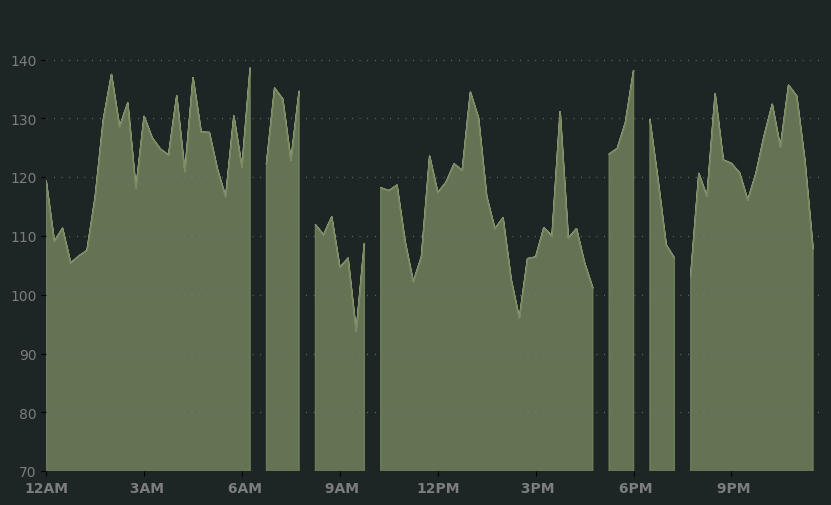

In [13]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.dates as mdates

healthy = 140

figsize = (10, 6)
fig = plt.figure(figsize=figsize, facecolor="#1d2525")

# set the grid style
ax = plt.axes()
# ax.yaxis.grid(linewidth='2', ls=":", dashes=(1,3,1,3), color="#7c7d7d")
ax.yaxis.grid(linewidth='1', ls=":", dashes=(0.5,5,0.5,5), color="#7c7d7d")

# remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# set colors
ax.set_facecolor("#1d2525")

# set the range and style of ticks
plt.yticks(np.arange(70.0, max(y1)+10, 10.0), color="#7c7d7d", fontsize=10)
plt.xticks(color="#7c7d7d")
plt.ylim(70, max(y1)+10)
plt.xlim(x[0], x[len(x)-1])

# set the xaxis labels to the time
xts = list(pd.date_range(start_date,datetime.strftime(datetime.strptime(end_date,"%Y-%m-%d")+timedelta(days=1),"%Y-%m-%d"), freq="3H"))
ax.set_xticklabels(xts, weight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%l%p'))

# smooth the plot points
y = list(gaussian_filter1d(y1, sigma=0.01*5))

# plot the graph and fill in the correct colors
plt.plot(x,y,color="#76885f", alpha=.0)
plt.plot(np.where(np.array(y)>= healthy, np.array(y), None), color="#c1c59a", label="1", alpha=.0)
plt.plot(np.where(np.array(y)<= healthy, np.array(y), None), color="#76885f", label="1", alpha=.0)

lower = np.array(y).clip(max=healthy)
upper = np.array(y)
#ax.fill_between(x, y, 0, color='#76885f', alpha=.8)

ax.fill_between(x, lower, upper, color='#c1c59a', alpha=.8)
ax.fill_between(x, 0, lower, color='#76885f', alpha=.8)

This plot is important because it quickly helps us visualize all of the continuous data collected by the monitor, as well as identify healthy ranges of glucose levels, spikes, and times when the participant failed to log data.

## 7.2 Glucose Scores

For our second chart, we will be attempting to replicate the glucose scores summary, which displays various statistics about your daily glucose levels.

<img src="https://i.imgur.com/4k5hgln.png" width='750px'>

The only data we will need here are the summary scores taken from the `scoremain` dictionary variable which we created during data extraction.

Here will begin by setting up the colors and score arrays:

In [14]:
import pandas as pd
import numpy as np

# colors dict: put a color for every index
# we will do: (0) peak, (1) average, (2) adaptability, (3) variability

scores = [scoremain["scorePeak"], scoremain["scoreMean"], scoremain["scoreTimeOutsideRange"], scoremain["scoreStdDev"]]
lpos = [-0.112,-0.06,0.0,-0.03]

# This will give us our desired 10-block bar chart
basescore = [0.1]*10
base2 = {'peak': basescore}
bg2 =pd.DataFrame(base2).transpose()

# the labels for the plots
lsb = ["Peak", "Average", "Adaptability", "Variability"]

# set an array of colors which will be used to determine partition coloring
colors = ['#343e33']
for score in scores:
  # divisions: 0-4, 5-7,
  if score <= 4:
    colors.append('#ff3e4d')
  elif score <= 7:
    colors.append('#ef893f')
  else:
    colors.append('#a9c180')
colors.append('#343e33')

All that is left for us to do now is tons of plotting and styling!

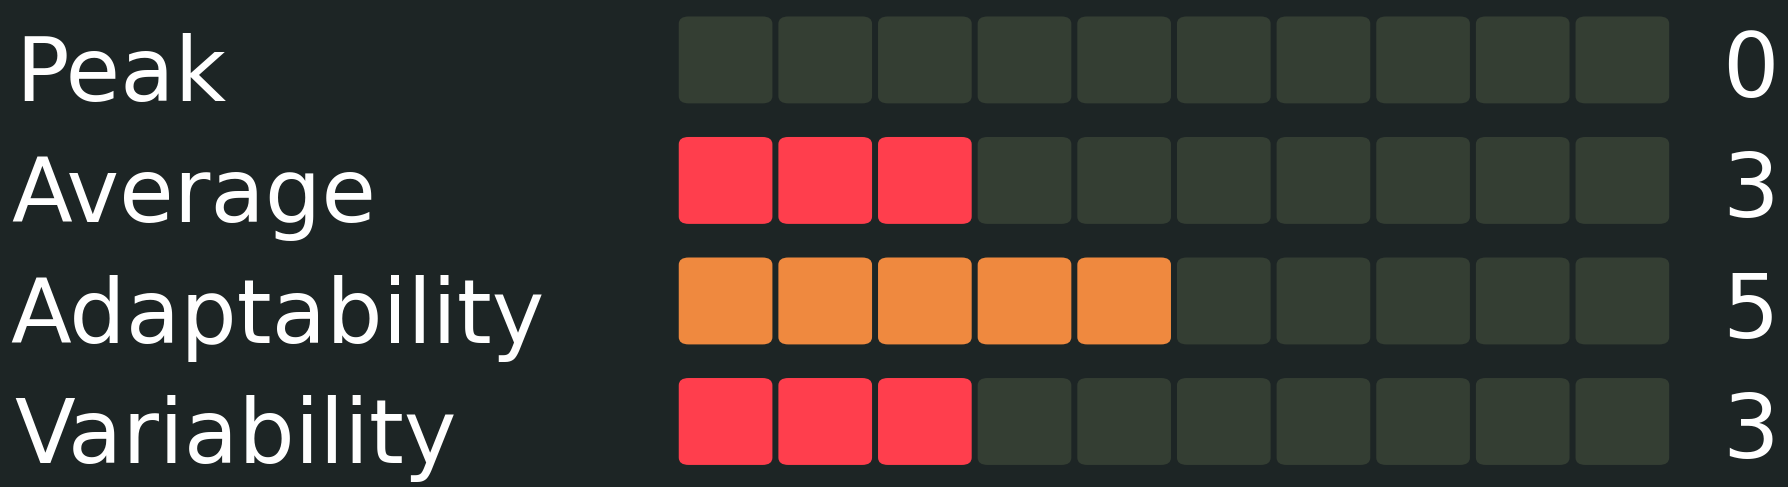

In [15]:
# position will tell matplotlib where to place each plot, figsize is dynamic based off of our number of plots
from collections import defaultdict
from matplotlib.patches import FancyBboxPatch

# initialize the figure
Position = range(1,5)
figsize = (18, 3*(4//3+1))
fig = plt.figure(figsize=figsize, facecolor="#1d2525")

for i in range(4):

  # color array that will be applied to the current plot
  cs = []
  for j in range(scores[i]):
    cs.append(colors[i+1])
  while len(cs) < 10:
    cs.append(colors[0])

  # add one bar chart for each statistic
  ax2 = fig.add_subplot(4, 1, Position[i], facecolor="#1d2525")
  ax = bg2.plot(kind='barh', stacked=True, legend=False, secondary_y=True, ax = ax2, xlim=(-0.4,1.), color=cs) # #343e33

  # redo the plot's elements to style it
  new_patches = []
  for patch in reversed(ax.patches):
    bb = patch.get_bbox()
    color=patch.get_facecolor()

    # the fancy bbox patch module gives us additional ways to customize
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.0030,rounding_size=0.010",
                        ec="none", fc=color,
                        mutation_aspect= 4
                        )
    patch.remove()
    new_patches.append(p_bbox)
  for patch in new_patches:
    ax.add_patch(patch)

  # set the ylabel and ylabel position
  ax.set_ylabel(lsb[i], color="white", fontsize=64, rotation=0, position=(0,0))
  ax.yaxis.set_label_coords(lpos[i],-0.1)
  ax.yaxis.set_label_position("left")

  plt.text(1.05,-0.2, str(int(scores[i])), fontsize=64, color="white")

  # remove frame
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)

  # remove frame
  ax2.spines['top'].set_visible(False)
  ax2.spines['right'].set_visible(False)
  ax2.spines['bottom'].set_visible(False)
  ax2.spines['left'].set_visible(False)

  # hide the ticks and tick labels
  plt.setp( ax.get_xticklabels(), visible=False)
  plt.setp( ax2.get_xticklabels(), visible=False)
  plt.setp( ax.get_yticklabels(), visible=False)
  plt.setp( ax2.get_yticklabels(), visible=False)
  plt.xticks([])
  plt.yticks([])

This plot gives us a simple and visually appealing way to visualize summary statistics for a patient's glucose levels, allowing us to easily identify which scores are considered bad and which are good depending on color coding.

## 7.3 Glucose Summary

The following is a box plot summarizing the daily glucose statistics. The text on the green rectangle gives the `Mean / Standard Deviation` and the caps represent the maximum/minimum.

The weekly is compared with the daily in this graph

<img src="https://i.imgur.com/X6lXdk7.png"/>

For this graph, the data we need will all come from the statistics variable we extracted at the start of this notebook.

In [16]:
s = [statistics["today"], statistics["average"]][::-1]

In [17]:
print(statistics)

{'today': {'healthyRange': {'min': 70.0, 'max': 140.0, '__typename': 'Range'}, 'range': {'min': 51.14815994331366, 'max': 165.12003700131407, '__typename': 'Range'}, 'timeWithinRange': 10023.0, 'min': 70, 'max': 140, 'mean': 105.92332823891968, 'median': 106.52577110359762, 'standardDeviation': 19.051715035245127, 'q1': 90.7, 'q3': 121.0, 'score': 0.0, '__typename': 'Stat'}, 'average': {'healthyRange': {'min': 70.0, 'max': 140.0, '__typename': 'Range'}, 'range': {'min': 79, 'max': 98, '__typename': 'Range'}, 'timeWithinRange': 88, 'min': 79, 'max': 98, 'mean': 91, 'median': 97, 'standardDeviation': 4, 'q1': 85, 'q3': 97, 'score': 0.0, '__typename': 'Stat'}}


In [18]:
print(s)

[{'healthyRange': {'min': 70.0, 'max': 140.0, '__typename': 'Range'}, 'range': {'min': 79, 'max': 98, '__typename': 'Range'}, 'timeWithinRange': 88, 'min': 79, 'max': 98, 'mean': 91, 'median': 97, 'standardDeviation': 4, 'q1': 85, 'q3': 97, 'score': 0.0, '__typename': 'Stat'}, {'healthyRange': {'min': 70.0, 'max': 140.0, '__typename': 'Range'}, 'range': {'min': 51.14815994331366, 'max': 165.12003700131407, '__typename': 'Range'}, 'timeWithinRange': 10023.0, 'min': 70, 'max': 140, 'mean': 105.92332823891968, 'median': 106.52577110359762, 'standardDeviation': 19.051715035245127, 'q1': 90.7, 'q3': 121.0, 'score': 0.0, '__typename': 'Stat'}]


Since matplotlib's default boxplot looks a farcry from the beautiful plot featured, we have some extra work to do!

Since we are plotting this chart straight from precalculated statistics, we will be using the `bxp` function rather than the standard `boxplot`.

<ipython-input-19-e744c844c7c9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["average", "today"], rotation=90, ha='center', rotation_mode='anchor', weight="bold")
<ipython-input-19-e744c844c7c9>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([lbound,rbound], ha='center', rotation_mode='anchor', weight="bold", color="#a6a8a7")


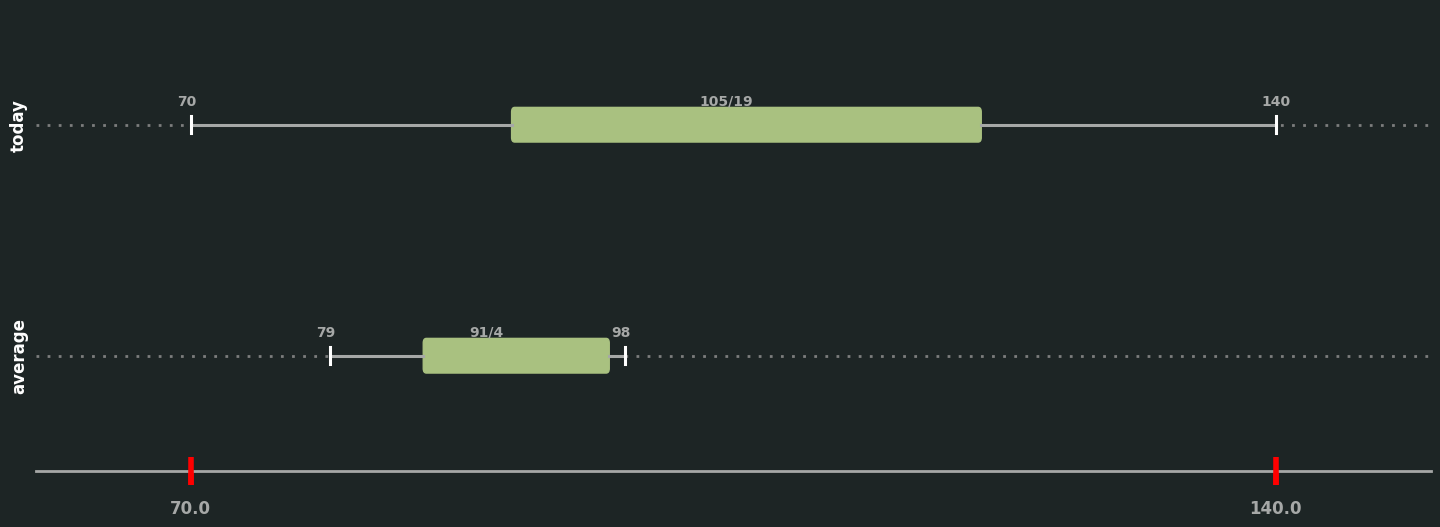

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# boxplot for daily and weekly
# bottom line is healthy range
# daily is min and max

# plt.boxplot()
figsize = (18, 6)

# healthy range:
lbound, rbound = 70.0, 140.0

# vars
labels = ["average", "today"]
medianprops = {"linestyle":'none'}
whiskerprops = {"color": "#a6a8a7","linewidth":2.2}
capprops = {"color": "white","linewidth":2.2}

stat_data = []
for i in range(len(s)):
  d = s[i]
  mn, mx = d["min"], d["max"]
  avg, sd = d["mean"], d["standardDeviation"]
  q1, q3 = d["q1"], d["q3"]

  stat_data.append({'med': avg, 'q1': q1, 'q3':q3, 'whislo': mn, 'whishi': mx, 'label': labels[i]})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, facecolor="#1d2525")
ax.yaxis.grid(linewidth='2', ls=":", dashes=(1,3,1,3), color="#7c7d7d")
ax.set_axisbelow(True)

ax.tick_params(axis='y',colors='white', labelrotation=90, labelsize=12, pad=10)

# might want to change below into a self drawn patch tick
ax.tick_params(axis='x',colors='red', width=4.0, length=10.0, labelsize=12, pad=10, bottom=100)


ax.set_yticklabels(["average", "today"], rotation=90, ha='center', rotation_mode='anchor', weight="bold")
ax.set_xticklabels([lbound,rbound], ha='center', rotation_mode='anchor', weight="bold", color="#a6a8a7")
plt.tick_params(left = False)

bplot = ax.bxp(
    stat_data,
    showfliers=False,
    vert=False,
    patch_artist=True,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    )

new_patches = []

for patch in bplot['boxes']:
  bb = patch.get_path().get_extents()
  p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=0,rounding_size=0.2",
                        ec="#a9c180", fc="#a9c180",
                        mutation_aspect=0.1)
  patch.remove()
  new_patches.append(p_bbox)

for i in range(len(new_patches)):
  patch = new_patches[i]
  ax.add_patch(patch)
  l, r = patch.get_x(), patch.get_x() + patch.get_width()
  h = patch.get_y() + patch.get_height()
  plt.text((l+r)/2-3, h+0.01, str(int(s[i]['mean']))+"/"+str(int(s[i]['standardDeviation'])), color="#a6a8a7", fontweight='semibold')
  plt.text(s[i]['min']-0.9,h+0.01, str(int(s[i]['min'])), color="#a6a8a7", fontweight='semibold')
  plt.text(s[i]['max']-0.9,h+0.01, str(int(s[i]['max'])), color="#a6a8a7", fontweight='semibold')

plt.xlim(60.0, max(s[0]['max'], s[1]['max'])+10)
plt.xticks([lbound, rbound])

# set colors
ax.set_facecolor("#1d2525")

# remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set(color="#a6a8a7", linewidth=2.0)
ax.spines['left'].set_visible(False)

# add the inner side to the ticks
ax2 = ax.twiny()
ax2.axis('off')

ax4 = ax2.twiny()
ax4.tick_params(axis="x",direction="out", pad=-15, bottom = True, top=False)
ax4.spines['bottom'].set(color="#a6a8a7", linewidth=2.0)
ax4.tick_params(axis='x',colors='red', width=4.0, length=10.0, labelsize=12, pad=10, bottom=100)
ax4.xaxis.set_ticklabels([])
ax4.set_xlim(ax.get_xlim())
ax4.set_xticks([lbound,rbound])

ax3 = ax2.twiny()
ax3.tick_params(axis="x",direction="in", pad=-15, bottom = True, top=False)
ax3.spines['bottom'].set(color="#a6a8a7", linewidth=2.0)
ax3.tick_params(axis='x',colors='red', width=4.0, length=10.0, labelsize=12, pad=10, bottom=100)
ax3.xaxis.set_ticklabels([])
ax3.set_xlim(ax.get_xlim())
ax3.set_xticks([lbound,rbound])

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)

This graph is helpful because it gives a quick look at how the participant's daily glucose level statistics match up to their overall weekly trend. It also gives us a view of the summary statistics of the glucose levels.

# 8. Outlier Detection and Data Cleaning

**NOTICE:** If you are using synthetically generated data, the analyses may yield unintuitive results due to the randomly generated nature of the data

In this section, we will detect outliers in our extracted data.

Since there are currently no outliers (by construction, since it is simulated to have none), we will manually inject a couple into our general sessions dataframe (the method for finding outliers here will work for any heart rate dataframe).

In [20]:
import pandas as pd
from datetime import datetime, timedelta

dToStr = lambda x: datetime.strftime(x,"%Y-%m-%dT%H:%M:%S")

last = list(data['time'])[len(data)-1]
last, apd = last[:19], last[19:]

ctime = datetime.strptime(last, "%Y-%m-%dT%H:%M:%S")
t1, t2 = dToStr(ctime + timedelta(minutes=15))+apd, dToStr(ctime + timedelta(minutes=30)) + apd
outliers = {'time': [t1, t2], 'level': [240, 280]}
odata = data.append(pd.DataFrame(outliers),ignore_index=True)
display(odata)

<ipython-input-20-b12de2019810>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  odata = data.append(pd.DataFrame(outliers),ignore_index=True)


,time,level,interpolated
0,2022-03-01T00:15:00-08:00,122.153035,False
1,2022-03-01T00:30:00-08:00,144.575065,False
2,2022-03-01T00:45:00-08:00,135.063114,True
3,2022-03-01T01:00:00-08:00,133.561388,False
4,2022-03-01T01:15:00-08:00,132.108973,False
...,...,...,...
10460,2022-06-17T23:15:00-08:00,122.887501,False
10461,2022-06-17T23:30:00-08:00,107.835660,False
10462,2022-06-17T23:45:00-08:00,102.928913,True
10463,2022-06-18T00:00:00-08:00,240.000000,NaN


Now we need a method to find these outliers. While there are many known methods for finding outliers, one of the quickest ways is to use something known as a z-score.

The formula for the z-score is


```
Z = (data point - mean of data set) / standard deviation
```
We will compute this formula on every data point in our data set, giving us a massive list of z-score values.

What the z score tells us is how far, in terms of standard deviations, any one data point is from the mean. In statistics, data points at increasing standard deviations away from the mean are less likely to occur. This means that the greater our z-score, the more unlikely for the data point to be real.

We can decide what distance from the mean constitutes an outlier by setting the **threshold** value, so if a data point's z-score is above that threshold we might guess it to be an outlier.

One intuitive idea is that the glucose levels should not vary too much from one second to the next. To capitalize on this, we can improve our analysis by first calculating the distance each glucose level sample is away from neighboring glucose level samples. We can then use the z-scores to determine which glucose levels differ from their neighbors by an unusually large margin. These will likely be our outliers.

In [21]:
import math
import pandas as pd

nx = odata["level"]

distances = []

f = lambda x: x**2

#take the current count, subtract it by the points to its left and right some distance, then
#square each of these differences, add, then sqrt
for l1, l2, m, r1, r2 in zip(nx[:-4],nx[1:-3],nx[2:-2],nx[3:-1],nx[4:]):
  difference = math.sqrt(f(m-l1)+f(m-l2)+f(m-r1)+f(m-r2))
  distances.append(difference)

Now we can calculate our z-scores for the heart rate data in one training session, and identify those data points that seem like outliers. Luckily, we can save some time by using the [z-score function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) from scipy's statistics library, which will give us a z-score calculation for all data points.

In [22]:
from scipy import stats
import pandas as pd
import numpy as np

threshold = 3 #@param{type: "integer"}
z_scores = np.abs(stats.zscore(nx))
odata['z'] = z_scores
lcs = list((odata.loc[odata['z'] > threshold]).index)


cx = list(odata["level"].values)
for idx in odata.index[odata['z'] > threshold].tolist():
  vals = cx[idx-3:idx-2]+cx[idx-2:idx-1]+cx[idx+1:idx+2]+cx[idx+2:idx+3]
  mean_val = np.mean(vals)
  odata.loc[idx, 'level'] = mean_val


It looks like the code was able to successfully identify the two outliers!

# 9. Data Analysis

https://colab.research.google.com/drive/1XTnsQ9DMDU1S7d7mieo2EpOPYAEfOaVb?usp=sharing

Dexcom notebook data analysis <-- use similar graph

Amount of time above 180 changes over time ("if" i changed behavior)

Todo:
1. Polar verity sense corrections
2. finish this
3. finish actigraph notebook
4. 10 min presentation for what i have done this quarter if i want to continue


## 9.1: Blood glucose level vs. time of day (day vs. night)

**This section is the same as the one presented in the dexcom g6 notebook**

Since people (generally) sleep at night and eat during the day, one hypothesis is that glucose values will be different during the day compared to the night. Let's see if this is true. First, we will get the glucose values for each day and separate them into day time and night time values. We define day time as 9AM to 12AM (midnight) and night time as 12AM (midnight) to 9 am here, although these values can be adjusted as dayStart and dayEnd in the code.

In [23]:
from datetime import time
import scipy.stats as stats

df = data

dayStart = time(9, 00, 00)
dayEnd = time(0, 00, 00)

allTimes = pd.to_datetime(df.loc[:,'time']).dt.time

if dayStart < dayEnd:
    mask = (allTimes >= dayStart) & (allTimes <= dayEnd)
else:
    mask = (allTimes >= dayStart) | (allTimes <= dayEnd)

df["Time of Day"] = mask
df["Time of Day"] = df["Time of Day"].map({True: 'Day', False: 'Night'})

Let's use [seaborn](https://seaborn.pydata.org/) to generate a scatter plot to take an initial look.

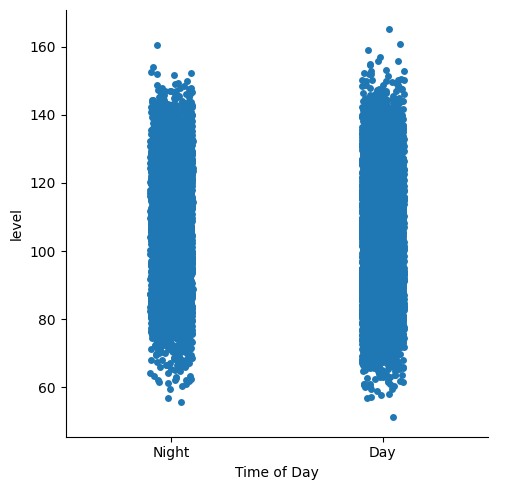

In [24]:
import seaborn as sns

sns.catplot(x="Time of Day", y="level", data=df)

Now, since we're compmaring two means, we could use a one-way ANOVA (analysis of variance). For this to be a valid analysis, we have to ensure the data is [independent, normally distributed, and homoscedastic](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/anova/).

Let's check normality first.

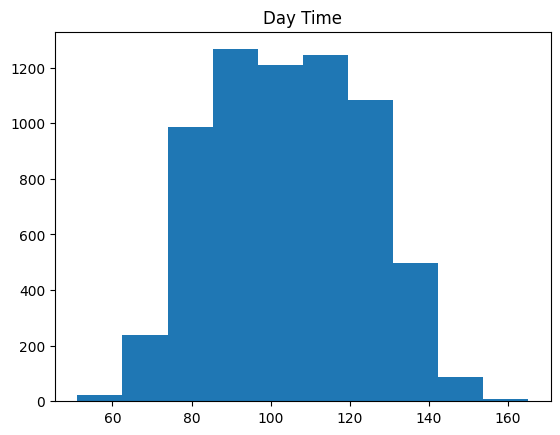

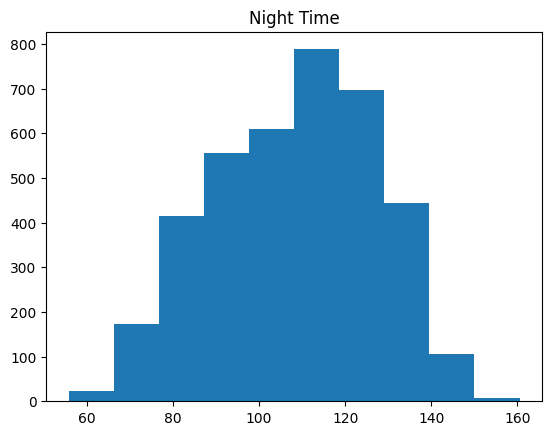

In [25]:
import matplotlib.pyplot as plt

plt.hist(df.loc[df["Time of Day"] == 'Day']['level'])
plt.title("Day Time")
plt.show()

plt.hist(df.loc[df["Time of Day"] == 'Night']['level'])
plt.title("Night Time")
plt.show()

Since the data do not look normally distributed, we can use a [Kruskal-Wallis test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal) instead of an ANOVA.

In [26]:
from scipy import stats

stats.kruskal(df.loc[df["Time of Day"] == 'Day']['level'],df.loc[df["Time of Day"] == 'Night']['level'])

KruskalResult(statistic=93.83083717342379, pvalue=3.436755694680777e-22)

Thus we can reject the null hypothesis that the population medians do not significantly differ (p<\0.05), and that night time values are different from day time values.

## 9.2: Blood glucose level after change of behavior

Does a patient change their eating habits throughout the course of the study When a patient changes their eating habits in order to keep their glucose levels in check, does it work? One analysis we could do is, given the date at which the patient started implementing changes in eating habits (like eating less sweets), determine if there is a significant difference in the blood glucose levels throughout the day (140 mg/dL).

For this type of question, we will use something called a T-Test, a statistical test used to determine compare the mean of some value in two separate groups. Here our first group will be the set of data before the patient changed their eating habits, and the second group will be the data after the patient changed their eating habits.

The date of behavioral change below can be modified as needed.

In [27]:
#@title Enter date of eating habit change

date_of_change = "2022-03-01T12:00:00" #@param {type:"string"}

In [28]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from datetime import timedelta, datetime
import re

df = data

pat = date_of_change + "*(.+)"

split = list(df["time"].str.match(pat).values)
split = split.index(True)


def differ(df):
  rows = len(df.index)
  f = df.iloc[range(split)]["level"]
  s = df.iloc[range(split,rows)]["level"]
  return ttest_ind(f,s)

print(differ(df))

TtestResult(statistic=-1.066404699796087, pvalue=0.2862653487369563, df=10461.0)


Since the t-test returned a negative value, this means the sample mean in the first half of the data is less than the sample mean in the second half of the data. Based on the increased glucose levels, it looks like the patient has indeed changed their eating habits, but for the worse!